In [299]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

In [300]:
# Custom dataset
class SymbolDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['image']
        label = self.data[idx]['label']
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, label['symbol'], label['indicator']

# Example data structure
data = [
    {"image": "./ResizedSymbols/SymbolA.png", "label": {"symbol": 0, "indicator": 0}},
    {"image": "./ResizedSymbols/SymbolA_R.png", "label": {"symbol": 0, "indicator": 1}},
    {"image": "./ResizedSymbols/SymbolB.png", "label": {"symbol": 1, "indicator": 0}},
    {"image": "./ResizedSymbols/SymbolB_R.png", "label": {"symbol": 1, "indicator": 1}},
    {"image": "./ResizedSymbols/SymbolC.png", "label": {"symbol": 2, "indicator": 0}},
    {"image": "./ResizedSymbols/SymbolC_R.png", "label": {"symbol": 2, "indicator": 1}},
    {"image": "./ResizedSymbols/SymbolD.png", "label": {"symbol": 3, "indicator": 0}},
    {"image": "./ResizedSymbols/SymbolD_R.png", "label": {"symbol": 3, "indicator": 1}},
    {"image": "./ResizedSymbols/SymbolE.png", "label": {"symbol": 4, "indicator": 0}},
    {"image": "./ResizedSymbols/SymbolE_R.png", "label": {"symbol": 4, "indicator": 1}},
    {"image": "./ResizedSymbols/SymbolF.png", "label": {"symbol": 5, "indicator": 0}},
    {"image": "./ResizedSymbols/SymbolF_R.png", "label": {"symbol": 5, "indicator": 1}},
    {"image": "./ResizedSymbols/SymbolG.png", "label": {"symbol": 6, "indicator": 0}},
    {"image": "./ResizedSymbols/SymbolG_R.png", "label": {"symbol": 6, "indicator": 1}},
    {"image": "./ResizedSymbols/SymbolH.png", "label": {"symbol": 7, "indicator": 0}},
    {"image": "./ResizedSymbols/SymbolH_R.png", "label": {"symbol": 7, "indicator": 1}},
]

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = SymbolDataset(data, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [301]:
class SymbolCNN(nn.Module):
    def __init__(self):
        super(SymbolCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # Output: (32, 18, 18)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # Output: (64, 16, 16)
        self.pool = nn.MaxPool2d(2, 2)  # Output: (64, 8, 8)

        self.flattened_size = 64 * 8 * 8
        self.fc_symbol = nn.Linear(self.flattened_size, 8)
        self.fc_indicator = nn.Linear(self.flattened_size, 1)

    def forward(self, x):
        features_1 = F.relu(self.conv1(x))
        features_2 = self.pool(F.relu(self.conv2(features_1)))
        flattened_features = features_2.view(features_2.size(0), -1)

        symbol_out = self.fc_symbol(flattened_features)
        indicator_out = torch.sigmoid(self.fc_indicator(flattened_features))

        return symbol_out, indicator_out, features_2  # Return intermediate features


model = SymbolCNN()


In [302]:
criterion_symbol = nn.CrossEntropyLoss()
criterion_indicator = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [303]:
epochs = 300
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, symbol_labels, indicator_labels in dataloader:
        # Move data to device if using GPU
        images = images.to('cpu')  # Replace 'cpu' with 'cuda' if using GPU
        symbol_labels = symbol_labels.to('cpu')
        indicator_labels = indicator_labels.to('cpu').float()

        # Forward pass
        symbol_out, indicator_out, features = model(images)

        # Compute losses
        loss_symbol = criterion_symbol(symbol_out, symbol_labels)
        loss_indicator = criterion_indicator(indicator_out.squeeze(), indicator_labels)
        loss = loss_symbol + loss_indicator

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")

# Save the trained model's state dictionary
torch.save(model.state_dict(), "symbol_cnn.pth")
print("Model saved to symbol_cnn.pth")

Epoch 1, Loss: 2.784411668777466
Epoch 2, Loss: 2.6928019523620605
Epoch 3, Loss: 2.594778299331665
Epoch 4, Loss: 2.489612102508545
Epoch 5, Loss: 2.367126941680908
Epoch 6, Loss: 2.22719669342041
Epoch 7, Loss: 2.0784902572631836
Epoch 8, Loss: 1.9193120002746582
Epoch 9, Loss: 1.7510008811950684
Epoch 10, Loss: 1.5857042074203491
Epoch 11, Loss: 1.4239940643310547
Epoch 12, Loss: 1.2701771259307861
Epoch 13, Loss: 1.1359708309173584
Epoch 14, Loss: 1.0156667232513428
Epoch 15, Loss: 0.9167487621307373
Epoch 16, Loss: 0.836531400680542
Epoch 17, Loss: 0.7709903717041016
Epoch 18, Loss: 0.7227067947387695
Epoch 19, Loss: 0.6816149950027466
Epoch 20, Loss: 0.6527249217033386
Epoch 21, Loss: 0.6254791021347046
Epoch 22, Loss: 0.6060706377029419
Epoch 23, Loss: 0.585971474647522
Epoch 24, Loss: 0.5701329708099365
Epoch 25, Loss: 0.5537105798721313
Epoch 26, Loss: 0.5379449129104614
Epoch 27, Loss: 0.5238439440727234
Epoch 28, Loss: 0.5071501135826111
Epoch 29, Loss: 0.493485689163208
Epo

Feature map shape: torch.Size([16, 64, 8, 8])
Visualizing features for image 1


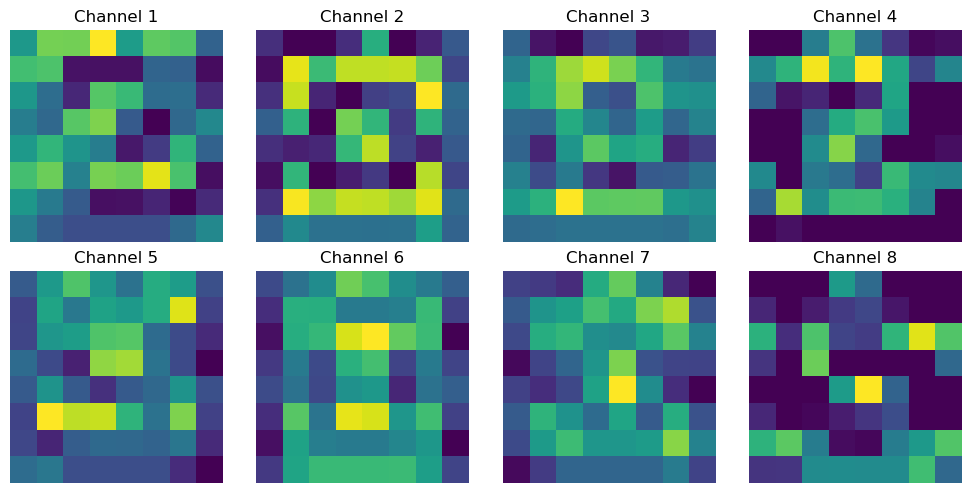

Visualizing features for image 2


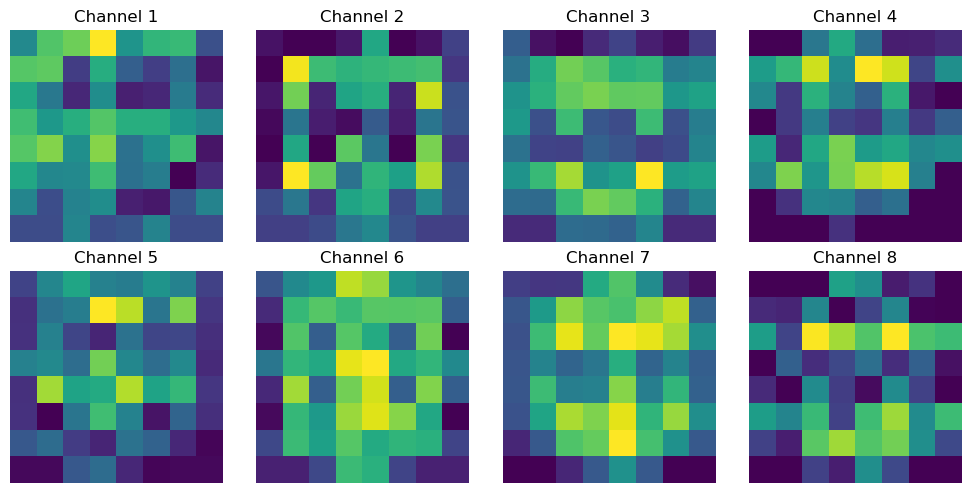

Visualizing features for image 3


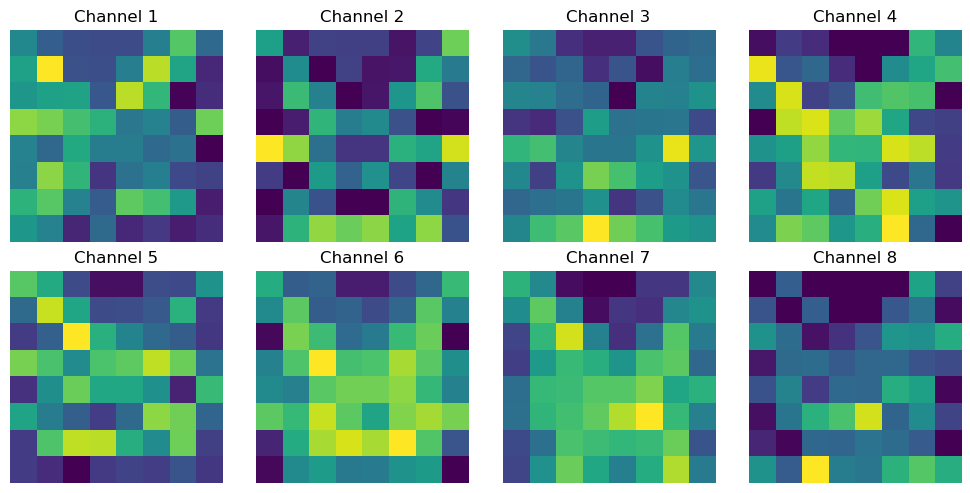

Visualizing features for image 4


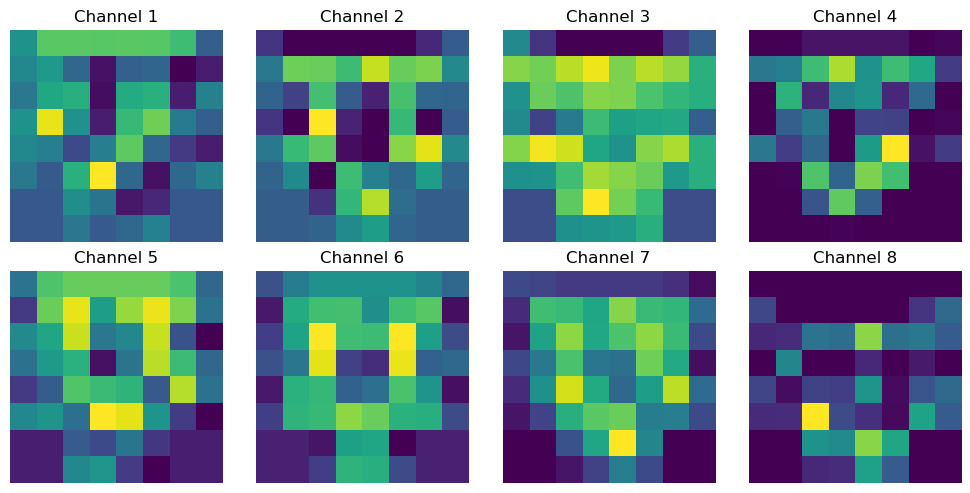

Visualizing features for image 5


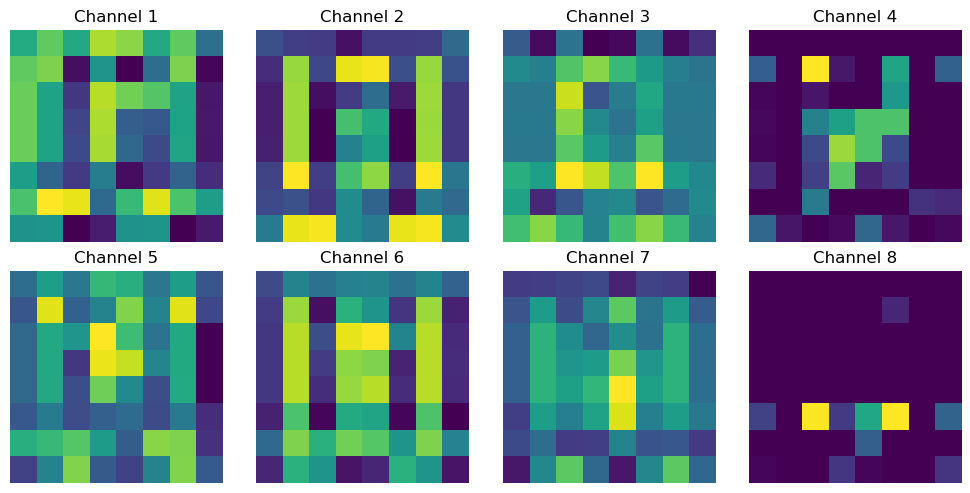

Visualizing features for image 6


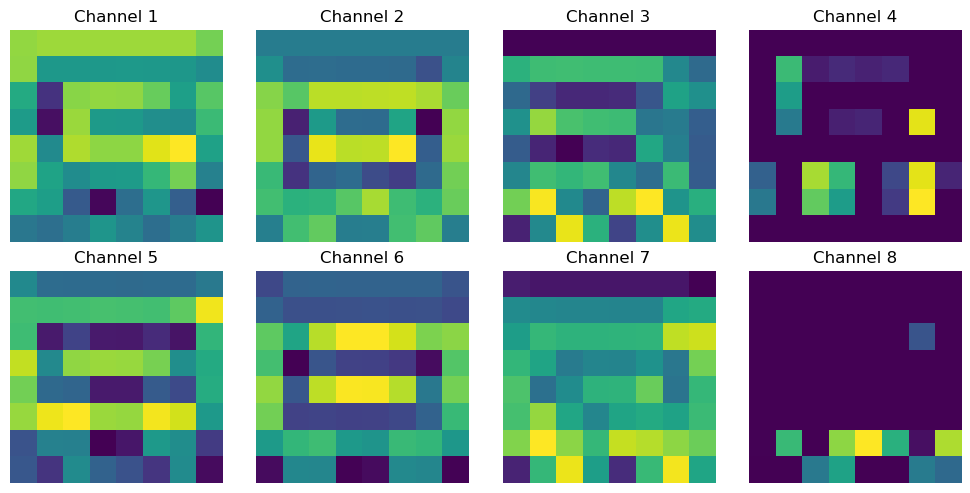

Visualizing features for image 7


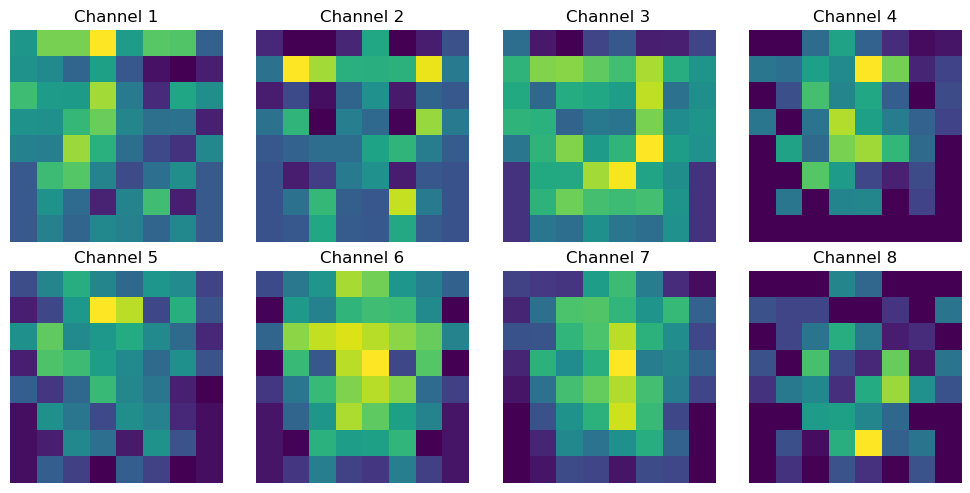

Visualizing features for image 8


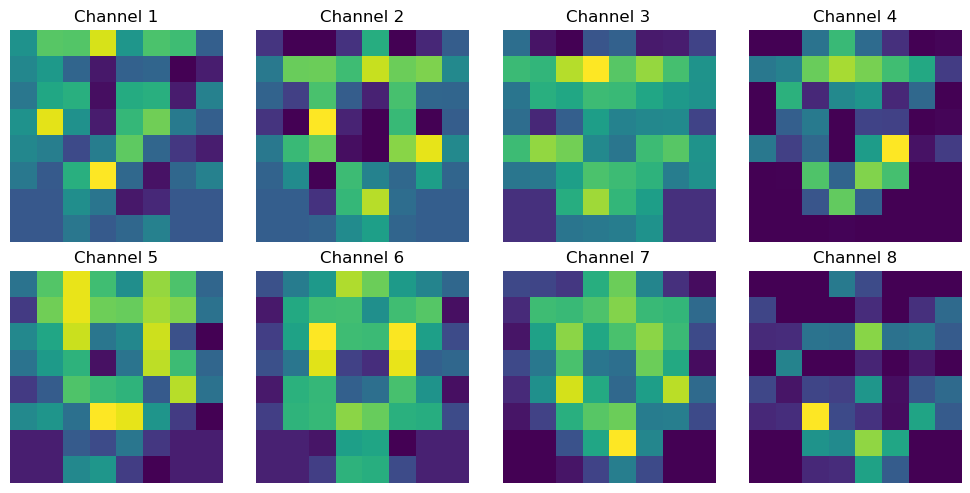

Visualizing features for image 9


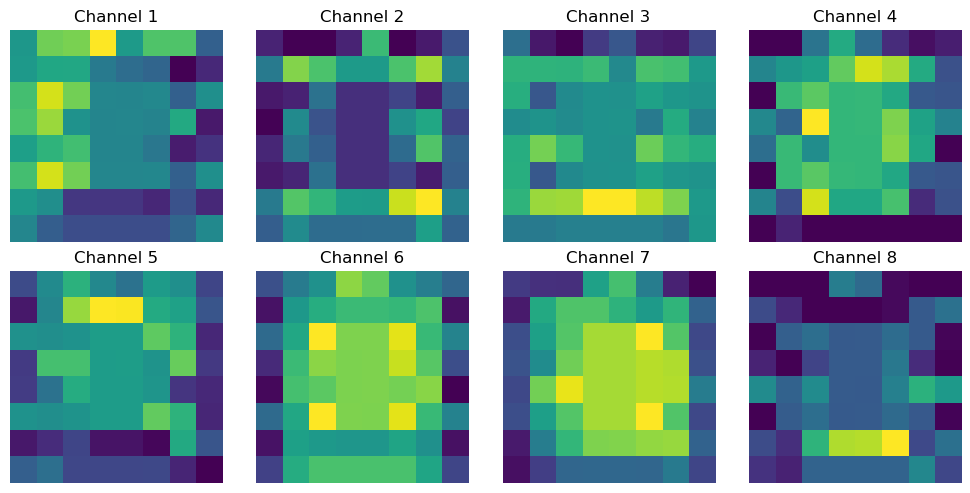

Visualizing features for image 10


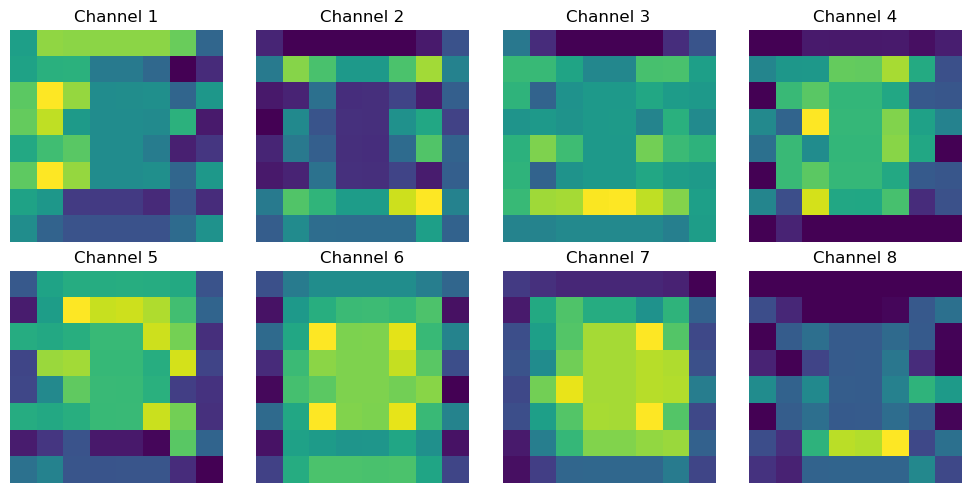

Visualizing features for image 11


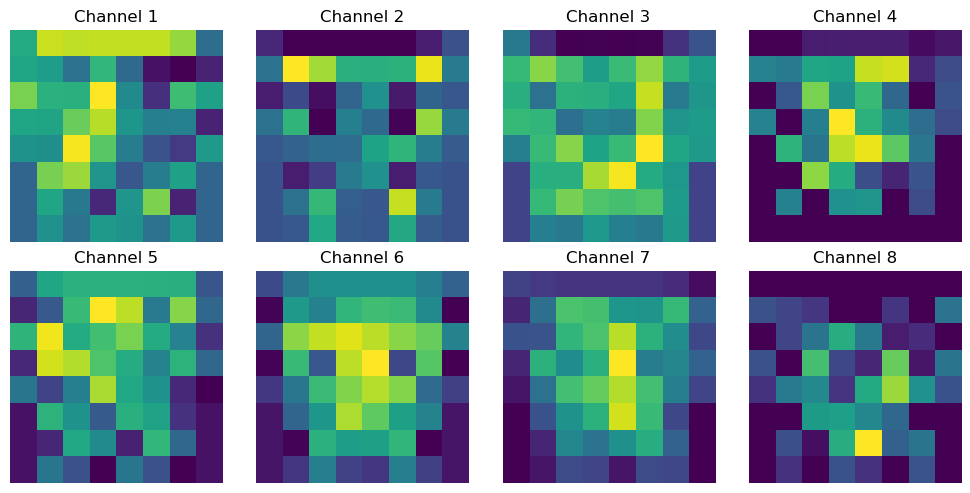

Visualizing features for image 12


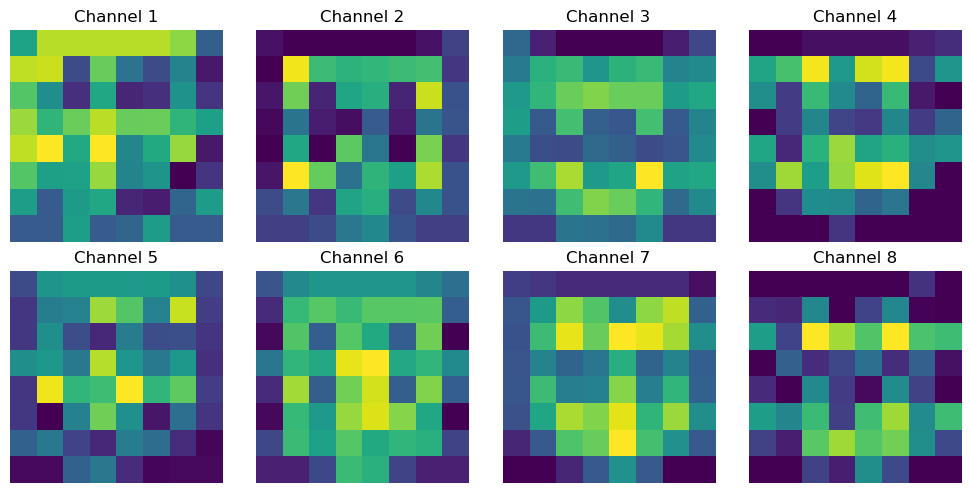

Visualizing features for image 13


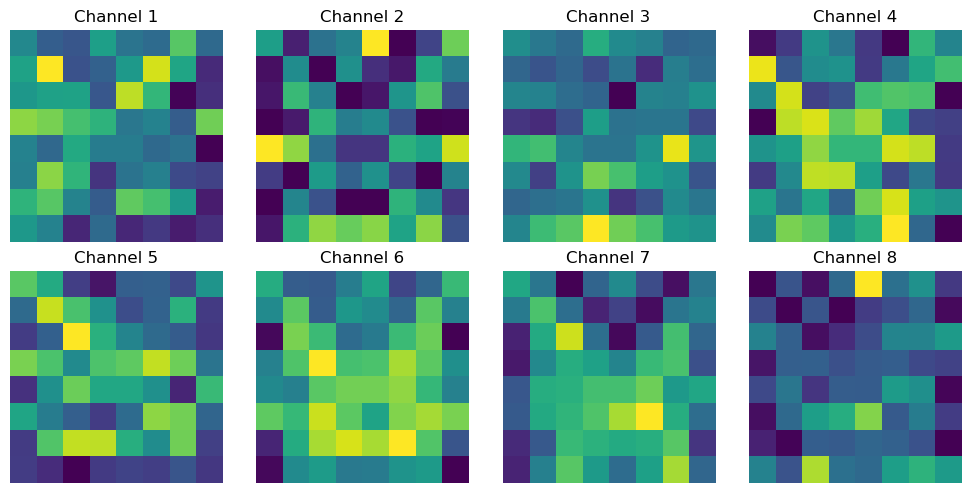

Visualizing features for image 14


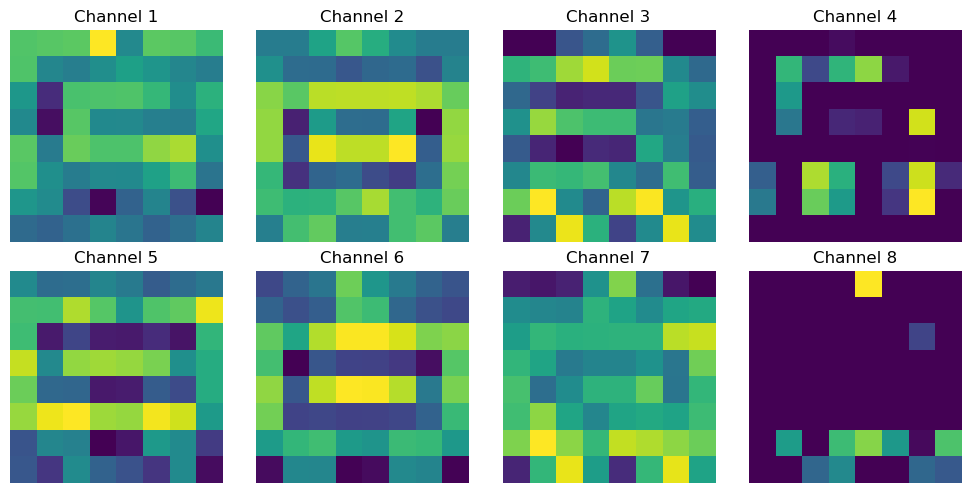

Visualizing features for image 15


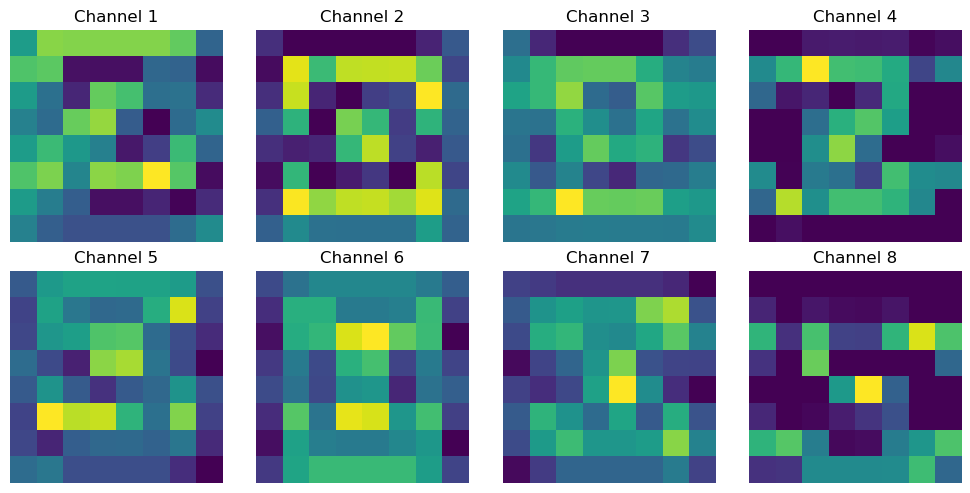

Visualizing features for image 16


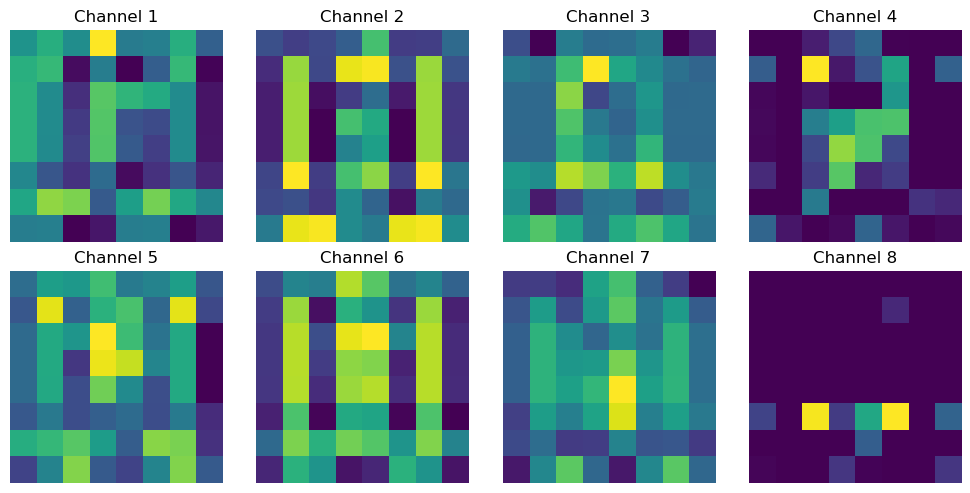

In [304]:
features = {}

def hook_fn(module, input, output):
    features["conv2"] = output  # Save the output of this layer

# Attach the hook to the desired layer
model = SymbolCNN()
model.conv2.register_forward_hook(hook_fn)

# Forward pass through the model
symbol_out, indicator_out, features = model(images)  # Extract all outputs

# Access the features saved by the hook or returned
feature_map = features  # Feature map from conv2 or whichever layer you’re monitoring
print("Feature map shape:", feature_map.shape)

# Feature map shape: (channels, height, width), e.g., (64, 8, 8)
feature_map_batch = feature_map.detach().cpu()  # Detach and move to CPU
# Select the first image's feature map from the batch
for img_idx in range(feature_map_batch.size(0)):  # Iterate over batch
    feature_map = feature_map_batch[img_idx]  # Select each image's feature map
    print(f"Visualizing features for image {img_idx + 1}")

    # Visualize channels (repeat visualization code)
    num_channels = feature_map.size(0)
    num_to_plot = min(8, num_channels)
    plt.figure(figsize=(10, 5))
    for i in range(num_to_plot):
        plt.subplot(2, 4, i + 1)
        plt.imshow(feature_map[i].detach().cpu().numpy(), cmap='viridis')
        plt.title(f"Channel {i + 1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [305]:
# Load the trained model
model = SymbolCNN()
model.load_state_dict(torch.load("symbol_cnn.pth"))  # Replace with your saved model path
model.eval()

# Define the same transform as used during training
transform = transforms.Compose([
    transforms.Resize((20, 20)),  # Resize to 20x20
    transforms.ToTensor(),       # Convert to tensor
])

# Function to make a prediction
def predict_image(model, image_path):
    # Load the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale

    # Apply preprocessing
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Pass the image through the model
    with torch.no_grad():  # No gradient calculation needed
        symbol_out, indicator_out, _ = model(image_tensor)

    # Decode the predictions
    symbol_index = torch.argmax(symbol_out, dim=1).item()  # Get the index of the highest score
    indicator_pred = (indicator_out > 0.5).item()          # Threshold at 0.5 for binary output

    # Map symbol index to the corresponding label
    #symbols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']  # Replace with your symbol mapping
    #symbol = symbols[symbol_index]

    # Return predictions
    return {'symbol': symbol_index, 'indicator': int(indicator_pred)}


C:\Users\Prod\AppData\Local\Temp\ipykernel_2456\510501193.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("symbol_cnn.pth"))  # Replace 

In [306]:
# Test the function with an image
input_directory = './Symbols/'

# Loop through all the files in the input directory
for filename in os.listdir(input_directory):
    # Only process image files (you can customize the condition)
    if filename.endswith(".png"):
        # Construct full file path
        input_path = os.path.join(input_directory, filename)

        prediction = predict_image(model, input_path)
        print("Prediction:", prediction)


Prediction: {'symbol': 0, 'indicator': 0}
Prediction: {'symbol': 0, 'indicator': 1}
Prediction: {'symbol': 1, 'indicator': 0}
Prediction: {'symbol': 1, 'indicator': 1}
Prediction: {'symbol': 2, 'indicator': 0}
Prediction: {'symbol': 2, 'indicator': 1}
Prediction: {'symbol': 3, 'indicator': 0}
Prediction: {'symbol': 3, 'indicator': 1}
Prediction: {'symbol': 4, 'indicator': 0}
Prediction: {'symbol': 4, 'indicator': 1}
Prediction: {'symbol': 5, 'indicator': 0}
Prediction: {'symbol': 5, 'indicator': 1}
Prediction: {'symbol': 6, 'indicator': 0}
Prediction: {'symbol': 6, 'indicator': 1}
Prediction: {'symbol': 7, 'indicator': 0}
Prediction: {'symbol': 7, 'indicator': 1}


In [309]:
# Test the function with an image
image_path = "./ResizedSymbols/SymbolA.png"  # Replace with your test image path
prediction = predict_image(model, image_path)
print("Prediction:", prediction)

Prediction: {'symbol': 0, 'indicator': 0}
